In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from IPython.display import HTML
import matplotlib.animation as animation

import sac
import envs
import utils

from rnet.model import RNetModel
from rnet.memory import RNetMemory
from rnet.utils import load
from exploration_buffer import ExplorationBuffer

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [86]:
logs_dir = '/checkpoint/sainbar/offline-gcrl/logs/'

#exp_name = "20220420-030857_walker_oracleFalse-rs1.0-lr0.0005-bs2048-alpha0.008-gamma0.85-action_repeat2-1goal-grid_search"
exp_name = "20220511_walker_policy2_allgoal_neg0.9_graph_lr0.001_gam0.9_rs1"

%ls '{logs_dir}{exp_name}/agent'

checkpoint_0.pth  checkpoint_100.pth  checkpoint_200.pth


In [93]:
ckpt = 200
ckpt_path = f'{logs_dir}{exp_name}/agent/checkpoint_{ckpt}.pth'

In [94]:
tmp_path = f"{logs_dir}/multirun/{exp_name}"
cfg_path = f"{tmp_path}/{os.listdir(tmp_path)[0]}/.hydra/config.yaml"

cfg = OmegaConf.load(cfg_path)

cfg.env.max_episode_steps=100

cfg.env.random_start_pos = False

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)

In [95]:
vis_cfg = cfg.copy()
env = envs.make_env(cfg.env, space_info)

if cfg.env.obs.type == 'vec':
    vis_cfg.env.obs.type = 'rgb'
    space_info_rgb = utils.get_space_info(vis_cfg.env.obs, vis_cfg.env.action_dim)
vis_env = envs.make_env(vis_cfg.env, space_info_rgb)

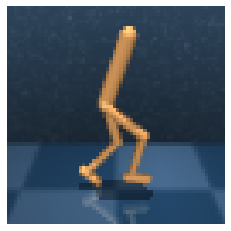

In [96]:
obs = vis_env.reset()
plt.imshow(obs['obs'].transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [97]:
device=torch.device("cuda:0")
space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)
agent = sac.SAC(cfg.sac, space_info, device)

agent.load_checkpoint(ckpt_path, evaluate=True)

Loading models from /checkpoint/sainbar/offline-gcrl/logs/20220511_walker_policy2_allgoal_neg0.9_graph_lr0.001_gam0.9_rs1/agent/checkpoint_200.pth


In [98]:
model = RNetModel(cfg.rnet.model, space_info)
model.to(device)
model.load(f'{logs_dir}{exp_name}/model.pth')
model.eval()

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=15, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [99]:
def get_reward(model, state):
    obs = torch.from_numpy(state['obs']).float().to(device).unsqueeze(0)
    goal = torch.from_numpy(state['goal_obs']).float().to(device).unsqueeze(0)
    return model(obs, goal, batchwise=True)[:, 0].item()

def generate_episode_walker(env, goal_idx=None, vis=True, rnet_val=False):
    video = []
    if rnet_val:
        rewards = []
    state = env.reset(goal_idx=goal_idx)
    #print(env.get_goals()[env.get_goal_idx()])
    #print(rnet.memory.states[env.get_goal_idx()])
    if vis:
        img = env.get_image()
        video.append(np.concatenate((img, env.goals['rgb_obs'][env.goal_idx]), axis=2).transpose(1, 2, 0))
    for i in range(cfg.env.max_episode_steps//cfg.env.action_repeat):
        with torch.no_grad():
            action = agent.select_action(state.copy(), evaluate=True)
            #print(action)
        state, reward, done, info = env.step(action)
        if vis:
            img = env.get_image()
            video.append(np.concatenate((img, env.goals['rgb_obs'][env.goal_idx]), axis=2).transpose(1, 2, 0))
        if rnet_val:
            rewards.append(get_reward(model, state))
    if rnet_val:
        plt.plot(rewards)
        plt.grid()
        plt.plot([0]*len(rewards), ls='--', c='grey')
        plt.title('rnet value')
        plt.xlabel('step')
        plt.show()
    return info, np.array(video)

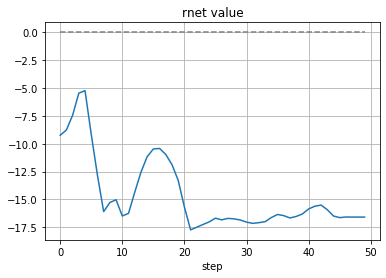

oracle_distance: 2.051
oracle_success: False


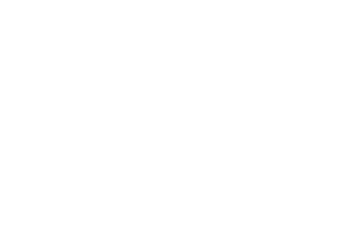

In [136]:
info, video = generate_episode_walker(env, goal_idx=11, vis=True, rnet_val=True)

print(f'oracle_distance: {round(info["oracle_distance"], 3)}')
print(f'oracle_success: {bool(info["oracle_success"])}')


imw = video.shape[2]
video[:, :, imw //2-1 : imw//2+1] = 0
fig = plt.figure()
plt.axis('off')
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=150, repeat=False)
plt.axis('off')
HTML(anim.to_jshtml())